In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

/tmp/ipykernel_28955/2011421623.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Get the merged malware data
df = pd.read_csv("vt_reports/merge.csv")
df.head()

,sha256,first_submission_date,family
0,98f8e26e12b978102fa39c197f300ebe5fe535617737d5...,1630575593,tnega
1,7b2999ffadbc3b5b5c5e94145ca4e2f8de66ac1e3ddd52...,1629375559,quasar
2,e7569d494fe00be04ef6c9fcc5e54720c0df623b08e79d...,1362057319,pasta
3,1ed60c04f572b6acb9f64c31db55ef5c6b5465bd4da1eb...,1630624233,cjishu
4,4c4aaff20a57213d9a786e56ad22f1eaa94694a2f1042b...,1592186154,kingsoft


In [3]:
# Convert the date to datetime
df1 = df.copy()
df1['first_submission_date'] = df['first_submission_date'].apply(
    lambda t: pd.to_datetime(t, unit='s')
)

<Figure size 1500x1000 with 0 Axes>

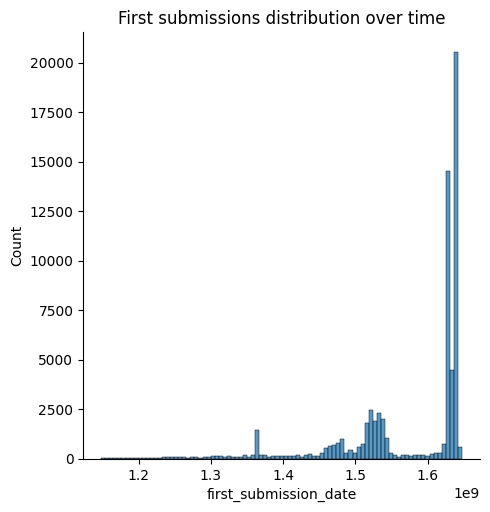

In [4]:
# Plot the distribution of first submissions over time
plt.figure(figsize=(15, 10))
dist_plot = sns.displot(df, x='first_submission_date')
plt.title("First submissions distribution over time")
plt.show()

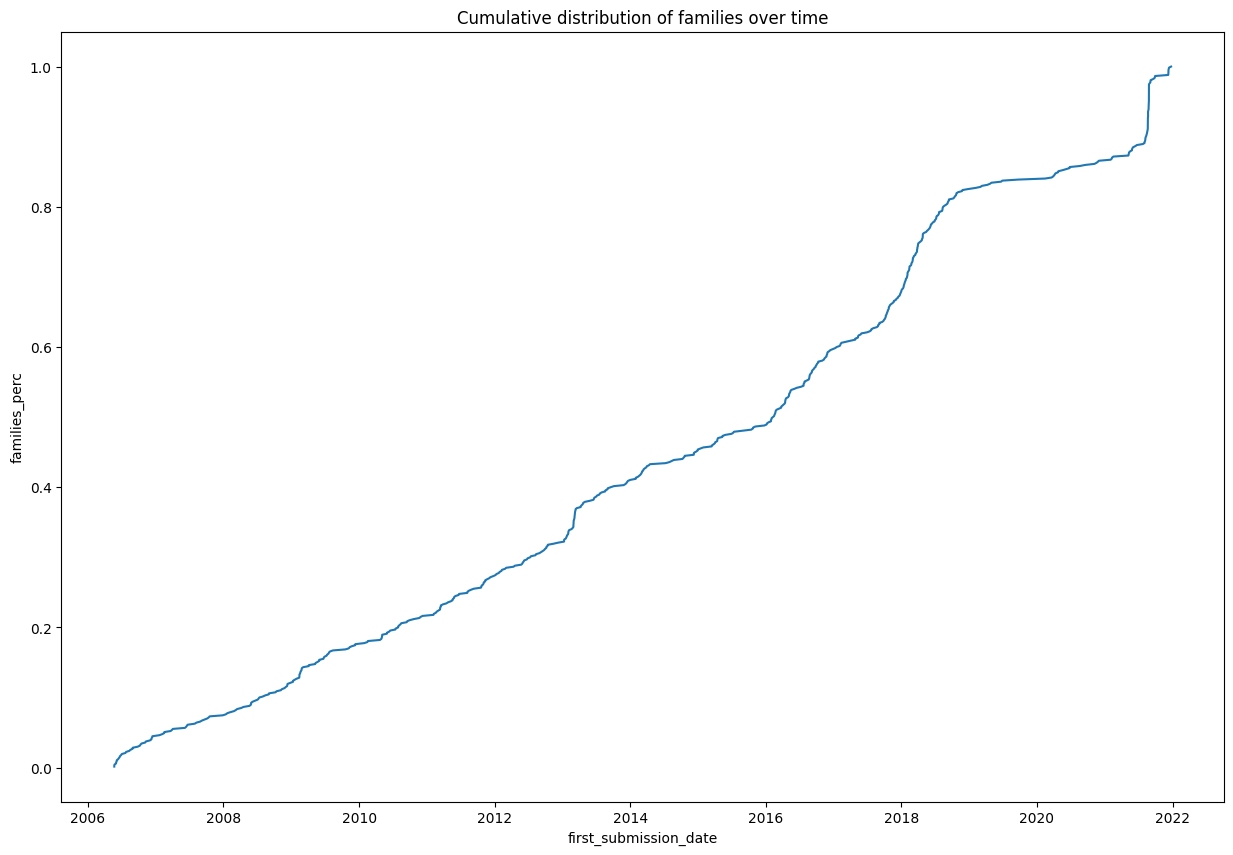

In [5]:
cumulative_df = pd.DataFrame(df1[["family", "first_submission_date"]], index=None)

# Group by the rows by the malware family, minimizing the first submission date
cumulative_df = cumulative_df.groupby(by=["family"]).min()

n = len(cumulative_df)
# For each timestamp, get the number of families previously discovered
cumulative_df['families_perc'] = cumulative_df['first_submission_date'].apply(
    lambda t: len(cumulative_df[cumulative_df['first_submission_date'] <= t]) / n
)

# Sort the submission date in ascending order
cumulative_df = cumulative_df.sort_values(by="first_submission_date")

# Plot the distribution of first submissions over time
plt.figure(figsize=(15, 10))
plt.title("Cumulative distribution of families over time")
sns.lineplot(cumulative_df, x="first_submission_date", y="families_perc")
plt.show()

In [6]:
# from sklearn.linear_model import LinearRegression
# import datetime as dt

# timestamp_to_datetime = lambda t: pd.to_datetime(t, unit='s')
# datetime_to_timestamp = lambda t: t.timestamp()

# min_year = pd.to_datetime(df["first_submission_date"].min(), unit='s').year
# max_year = pd.to_datetime(df["first_submission_date"].max(), unit='s').year

# print(f"min: {min_year}, max: {max_year}")


# #slope = np.zeros(max_year - min_year)

# def lin_reg_fit(df_split):
#     df_split.loc[:, "first_submission_date"] = df_split["first_submission_date"].apply(
#         lambda t: datetime_to_timestamp(t)
#     )
#     X, y = df_split[["first_submission_date"]].to_numpy(), df_split["families_perc"].to_numpy()
#     return LinearRegression().fit(X, y), X, y


# def plot_reg_pair(reg1_data, reg2_data):
#     reg1, X1, _ = reg1_data
#     reg2, X2, _ = reg2_data

#     X1_1 = timestamp_to_datetime(X1.ravel())
#     X2_1 = timestamp_to_datetime(X2.ravel())

#     df1 = pd.DataFrame({"first_submission_date": X1_1, "families_perc": reg1.predict(X1)})
#     df2 = pd.DataFrame({"first_submission_date": X2_1, "families_perc": reg2.predict(X2)})

#     # Plot the data points and the regression line
#     # plt.plot(pd.to_datetime(X1, unit='s'), reg1.predict(X1), color='red', label='Regression line of training set')
#     # plt.plot(pd.to_datetime(X2, unit='s'), reg2.predict(X2), color='blue', label='Regression line of test set')
#     # plt.xlabel('X')
#     # plt.ylabel('Y')
#     # plt.legend()
#     # plt.show()

#     plt.figure(figsize=(15, 10))
#     plt.title("Training/Test best split based on regression models")
#     sns.lineplot(df1, x="first_submission_date", y="families_perc")
#     sns.lineplot(df2, x="first_submission_date", y="families_perc")
#     plt.show()


# split = np.array_split(cumulative_df, (max_year - min_year) / 2)

# n = len(split) - 1
# slopes_diff = np.zeros(n)
# first_regressions_data = []
# sec_regressions_data = []

# for k in range(len(split) - 1):
#     df_first = pd.concat(split[:k + 1])
#     df_sec = pd.concat(split[k + 1:])

#     first_regressions_data.append(lin_reg_fit(df_first))
#     sec_regressions_data.append(lin_reg_fit(df_sec))

#     #plot_reg_pair(first_regressions_data[k], sec_regressions_data[k])
#     print(sec_regressions_data[k][0].coef_)
#     slopes_diff[k] = sec_regressions_data[k][0].coef_[0] - first_regressions_data[k][0].coef_[0]

# index_max = np.argmax(slopes_diff)

# plot_reg_pair(first_regressions_data[index_max], sec_regressions_data[index_max])

In [19]:
timestamp_to_datetime = lambda t: pd.to_datetime(t, unit='s')
datetime_to_timestamp = lambda t: t.timestamp()

def lin_reg_fit(df_split):
    df_split["first_submission_date"] = df_split["first_submission_date"].apply(
        lambda t: datetime_to_timestamp(t)
    );
    X, y = df_split[["first_submission_date"]].to_numpy(), df_split["families_perc"].to_numpy()
    return LinearRegression().fit(X, y), X, y

def plot_reg_pair(reg_data, j):
    fig, ax = plt.subplots()
    plt.title("Window-based linear regression")

    for i in range(len(reg_data)):
        reg, X, _ = reg_data[i]
        X1 = timestamp_to_datetime(X.ravel())
        df1 = pd.DataFrame({"first_submission_date": X1, "families_perc": reg.predict(X)})
        sns.lineplot(df1, x="first_submission_date", y="families_perc", linewidth=3 if i == j else 1, ax=ax)
    plt.show()

In [23]:
from sklearn.linear_model import LinearRegression

min_datetime = timestamp_to_datetime(df["first_submission_date"].min())
max_datetime = timestamp_to_datetime(df["first_submission_date"].max())

total_duration = max_datetime - min_datetime

def window_linear_regression(n_windows = 2):
    window_size = total_duration / n_windows
    
    windows = [i * window_size for i in range(n_windows + 1)]
    splits = [cumulative_df[
                  (cumulative_df["first_submission_date"] - min_datetime >= windows[i - 1]) & 
                  (cumulative_df["first_submission_date"] - min_datetime < windows[i])] 
              for i in range(1, len(windows))]
    
    regressions_data = []
    slopes = []
    for split in splits:
        regression_data = lin_reg_fit(split)
        regressions_data.append(regression_data)
        slopes.append(regression_data[0].coef_[0])
    
    index_max = np.argmax(slopes)
    plot_reg_pair(regressions_data, index_max)

In [24]:
%matplotlib inline
from ipywidgets import *

n_windows = max_datetime.year - min_datetime.year
interact(window_linear_regression, w=(2, n_windows, 1))

interactive(children=(IntSlider(value=2, description='n_windows', max=6, min=-2), Output()), _dom_classes=('wi…

<function __main__.window_linear_regression(n_windows=2)>